In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Base.classes.measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


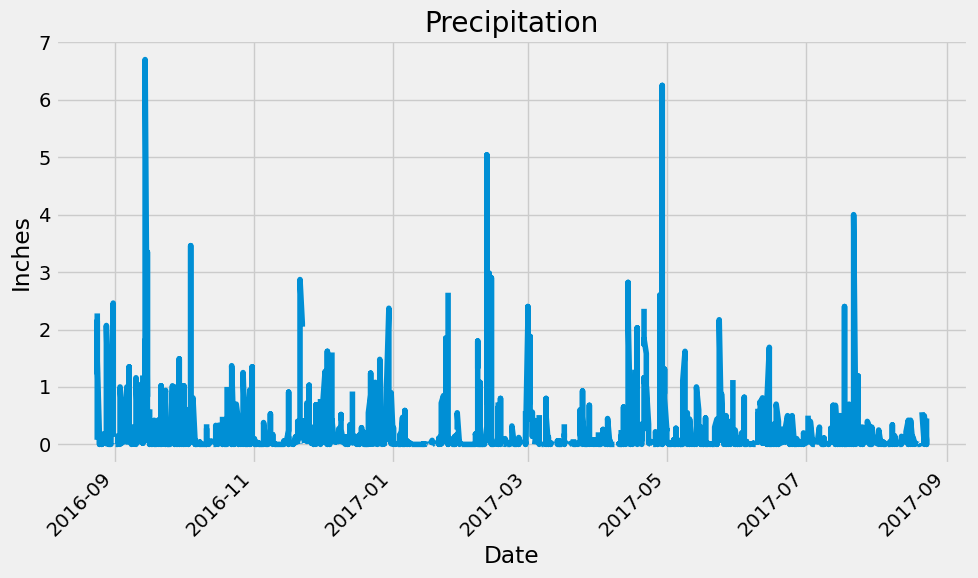

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

from datetime import datetime, timedelta 

# Step 1: Find the most recent date in the 'hawaii_measurement' table
most_recent_date = session.query(func.max(Base.classes.measurement.date)).scalar()

# Step 2: Convert the date string to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Step 3: Perform a query to retrieve the last 12 months of precipitation data
precip_data = session.query(Base.classes.measurement.date, Base.classes.measurement.prcp) \
    .filter(Base.classes.measurement.date >= one_year_ago) \
    .order_by(Base.classes.measurement.date).all()

# Step 4: Save the query results as a Pandas DataFrame and explicitly set column names
df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Step 5: Convert the 'date' column to datetime format and sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Step 6: Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(x='date', y='precipitation', kind='line', legend=False, ax=plt.gca())
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = df['precipitation'].describe()
print(precip_summary)




count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(station.station)).scalar()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to find the most active station
active_station = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .first()

most_active_station_id = active_station[0]
print(f"Most active station ID: {most_active_station_id}")

# Query to calculate the lowest, highest, and average temperatures
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()

lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most active station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


Most active station ID: USC00519281


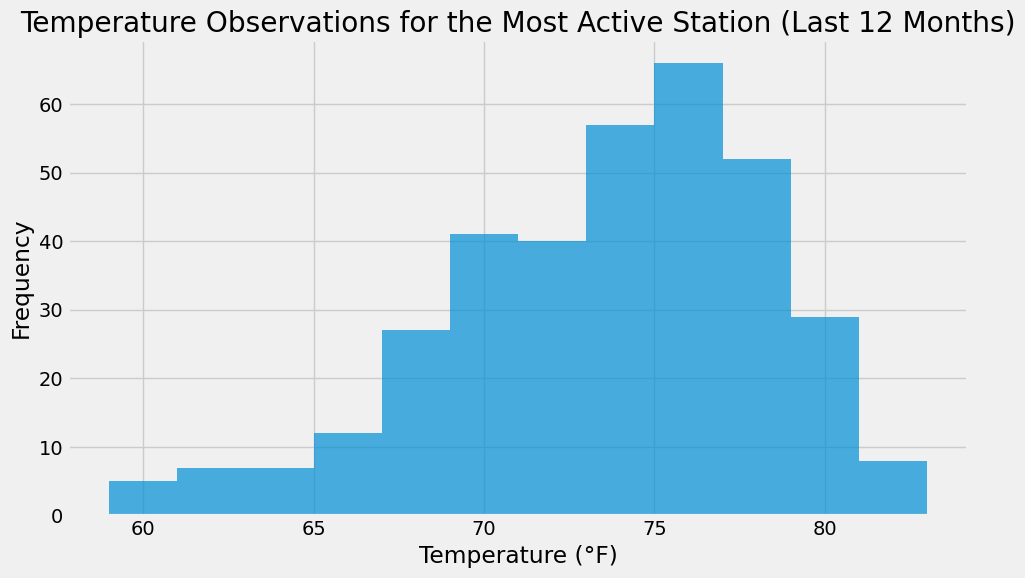

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to find the most active station
active_station = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .first()

most_active_station_id = active_station[0]
print(f"Most active station ID: {most_active_station_id}")

# Find the most recent date in the dataset
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Query to retrieve the last 12 months of temperature observation data
temp_data = session.query(measurement.date, measurement.tobs) \
    .filter(measurement.station == most_active_station_id) \
    .filter(measurement.date >= one_year_ago) \
    .order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(temp_data, columns=['date', 'temperature'])

# Plot the data as a histogram
plt.figure(figsize=(10, 6))
df['temperature'].plot(kind='hist', bins=12, alpha=0.7)
plt.title('Temperature Observations for the Most Active Station (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [25]:
# Close Session
session.close()